<h1 align = center>Introduction</h1><br>
<b>The task is</b> to obtain a power spectral density (PSD) from a signal or a group of signals , and to simulate random signals that have the same PSD. For now maintaining an original phase is optional. <br>
<b>The method is</b> to simulate signals in harmonic bases. For now we're using Fourier basis.<br>
<b>Sections:</b><br>
1. Simple 1D Fourier basis simulation <br>
2. Fast 1D Fourier simulation <br>
3. Fast multiple input multiple output 1D Fourier simulation <br>
4. Fast 2D Fourier simulation

<h1 align = center>1. Simple 1D Fourier basis simulation</h1>

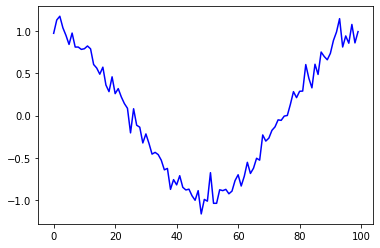

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.fft import ifft
import math
import cmath

# Period
T = 2 * np.pi
# Number of sample points
N = 100
# Linspace
t = np.linspace(0.0, T, N, endpoint=False)
# Signal
input_sig = np.cos(t) + np.random.normal(0, 0.1, N)
# Drawing
plt.plot(input_sig, 'b')

1.9293933965727872
0.026569473410327175


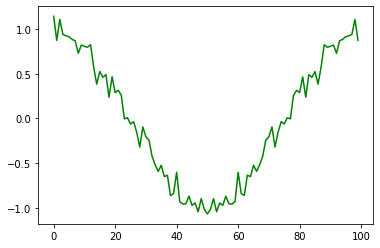

In [18]:
# Fourier transform
input_ft = fft(input_sig)
# PSD
input_psd = abs(input_ft)**2
# coefficients
coefs = np.sqrt(input_psd) / N
# turning noise into random signs
signs1 = np.sign(np.random.normal(0,1,N)) # Actually two noise arrays are not necessary
signs2 = np.sign(np.random.normal(0,1,N))
import cmath
output_sig1 = np.empty([100], dtype=complex)
for i in range(0, N):
    output_sig1[i] = 0
    for k in range(0, N // 2):
        output_sig1[i] += coefs[k] * (signs1[k] - 1j * signs2[k]) * cmath.exp(2j * k * i * math.pi / N)
        output_sig1[i] += coefs[k] * (signs1[k] + 1j * signs2[k]) * cmath.exp(2j * k * i * math.pi / N)
        # if we would only use signs1, then (1 - 1j) * x + (1 + 1j) * x = (1 - 1j + 1 + 1j) * x = 2 * x
output_sig1 = output_sig1.real
plt.plot(output_sig1.real, 'g')
# PSD accuracy
output_ft = fft(output_sig1)
output_psd = abs(output_ft)**2
print(max(abs(output_psd - input_psd)))
print(np.mean(abs(output_psd - input_psd)))
plt.show()

<h1 align = center>2. Fast 1D Fourier simulation</h1>

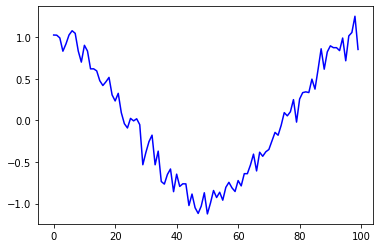

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.fft import ifft
import math
import cmath

# Period
T = 2 * np.pi
# Number of sample points
N = 100
# Linspace
t = np.linspace(0.0, T, N, endpoint=False)
# Signal
input_sig = np.cos(t) + np.random.normal(0, 0.1, N)
# Drawing
plt.plot(input_sig, 'b')
# Fourier transform
input_ft = fft(input_sig)
# PSD
input_psd = abs(input_ft)**2

In [20]:
def sim(coefs):
    N = len(coefs)
    output_sig = np.empty([N], dtype=complex)
    for i in range(0, N):
        output_sig[i] = 0
        for k in range(0, N // 2):
            output_sig[i] += 2 * coefs[k] * cmath.exp(2j * k * i * math.pi / N)
    output_sig = output_sig.real
    return output_sig    

# Based on Cooley-Tukey algo version found everywhere, works bad if starting N % 2 != 0
def sim_fast(coefs):
    N = len(coefs)
    if N == 1:
        return 0
    elif (N % 2 != 0) or (N < 10):
        return sim(coefs)
    else:
        sig_even = sim_fast(coefs[::2])
        sig_odd = sim_fast(coefs[1::2])
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        sig = np.concatenate([sig_even + factor[:int(N // 2)] * sig_odd, sig_even + factor[int(N // 2):] * sig_odd])
        return sig

Fast simulation
time:  0.0045926000000235945
max acc:  15.655784842082085
mean acc:  1.0343893623371427


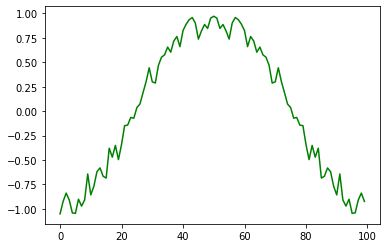

Slow simulation
time:  0.019528200000024754
max acc:  2.5298570574054264
mean acc:  0.03254159822873071


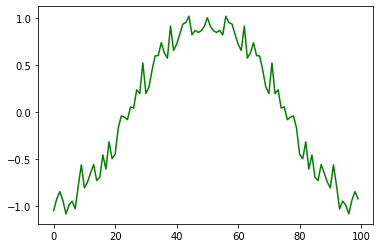

In [21]:
# Fourier transform
input_ft = fft(input_sig)
# PSD
input_psd = abs(input_ft)**2
# simulating
signs = np.sign(np.random.normal(0,1,N))
coefs = np.sqrt(input_psd) / N * signs

# fast simulation
import time
start_time = time.perf_counter()
output_sig = sim_fast(coefs)
stop_time = time.perf_counter()
plt.plot(output_sig.real, 'g')
print("Fast simulation")
print("time: ", stop_time - start_time)
# PSD accuracy
output_ft = fft(output_sig.real)
output_psd = abs(output_ft)**2
print("max acc: ", max(abs(output_psd - input_psd)))
print("mean acc: ", np.mean(abs(output_psd - input_psd)))
plt.show()

# slow simulation
start_time = time.perf_counter()
output_sig = sim(coefs)
stop_time = time.perf_counter()
plt.plot(output_sig.real, 'g')
print("Slow simulation")
print("time: ", stop_time - start_time)
# PSD accuracy
output_ft = fft(output_sig.real)
output_psd = abs(output_ft)**2
print("max acc: ", max(abs(output_psd - input_psd)))
print("mean acc: ", np.mean(abs(output_psd - input_psd)))
plt.show()

<h1 align = center>3. Fast multiple input multiple output 1D Fourier simulation</h1>

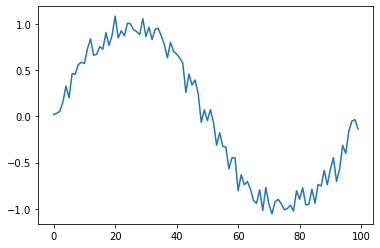

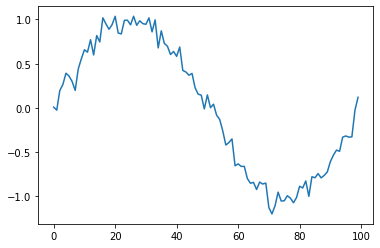

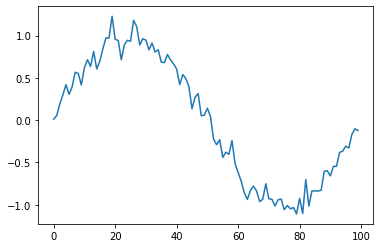

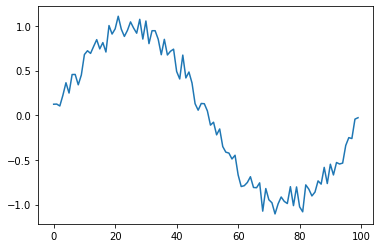

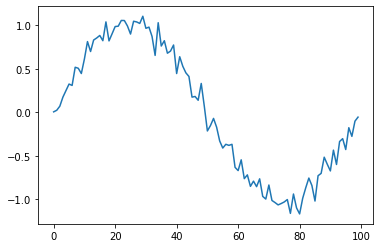

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.fft import ifft

# Period
T = 2 * np.pi
# Number of sample points
N = 100
# Number of input signals
n = 5
# Number of output signals
m = 10
# Linspace
t = np.linspace(0.0, T, N, endpoint=False)
# Signals
input_sigs = []
input_fts = []
input_psd = 0
input_avg = 0
input_max = 0
for i in range(n):
    # input signal shape
    input_sigs.append(np.sin(t) + np.random.normal(0, 0.1, N))
    input_fts.append(fft(input_sigs[i]))
    # PSD
    input_psd += abs(input_fts[i])**2
    plt.plot(input_sigs[i].real)
    plt.show()
input_psd /= n

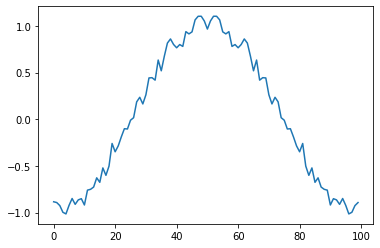

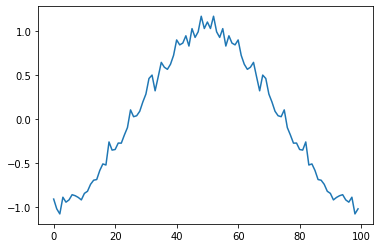

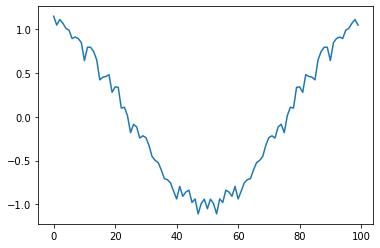

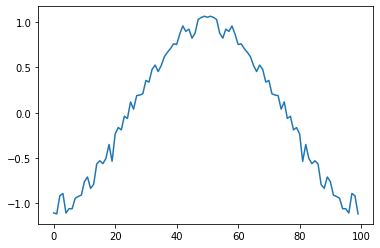

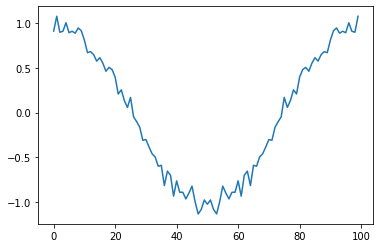

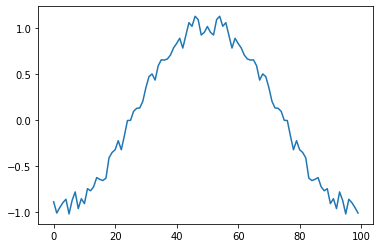

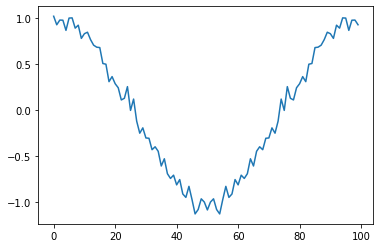

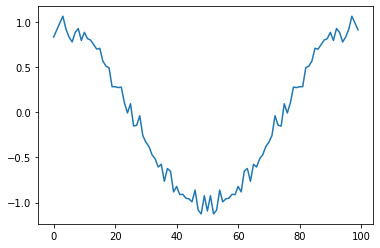

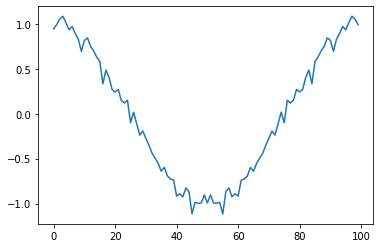

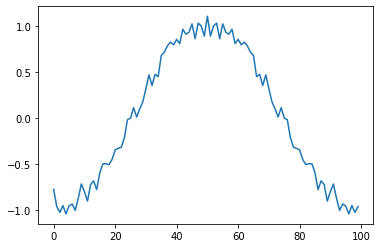

PSD accuracy
max acc:  181.02646882400722
mean acc:  4.425315010285109


In [25]:
output_psd = 0
for i in range(m):
    signs = np.sign(np.random.normal(0,1,N))
    coefs = np.sqrt(input_psd) / N * signs
    output_signal = sim_fast(coefs)
    output_psd += abs(output_ft)**2
    plt.plot(output_signal.real)
    plt.show()
output_psd /= m
print("PSD accuracy")
print("max acc: ", max(abs(output_psd - input_psd)))
print("mean acc: ", np.mean(abs(output_psd - input_psd)))

<h1 align = center>4. Fast 2D Fourier simulation</h1>

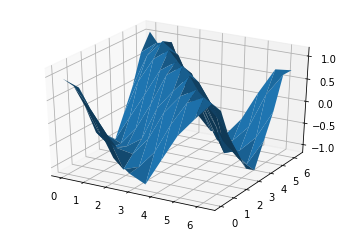

In [29]:
import numpy as np
import pandas as pd
import math
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.fft import fft2
from scipy.fft import ifft2
# Period
T = T1 = T2 = 2 * np.pi
# Number of sample points
N = N1 = N2 = 10
# Linspace
x, y = np.meshgrid(np.linspace(0.0, T1, N1), np.linspace(0.0, T2, N2))
# Original signal
input_sig = np.cos(x + y) + np.random.normal(0, 0.1, [N1, N2])
# Drawing
fig = plt.figure()
axis = fig.add_subplot(111, projection='3d')
axis.plot_surface(x, y, input_sig)

In [30]:
def sim2(coefs):
    N1, N2 = np.shape(coefs)
    output_sig = np.empty([N1, N2], dtype=complex)
    for i1 in range(0, N1):
        for i2 in range(0, N2):
            output_sig[i1][i2] = 0
            for k1 in range(1, N1 // 2):
                for k2 in range(1, N2 // 2):
                    output_sig[i1][i2] += 2 * coefs[k1][k2] * np.exp(2j * math.pi * (k1 * i1 / N1 + k2 * i2 / N2))
    output_sig = output_sig.real
    return output_sig
    
def sim2_fast(coefs):
    N1, N2 = np.shape(coefs)
    if N1 * N2 == 1:
        return 0
    elif N % 2 != 0:
        return sim2(coefs)
    else:
        sig_even = sim2_fast(coefs[::2, ::2])
        sig_odd = sim2_fast(coefs[1::2, 1::2])
        n1 = np.linspace(1, N1, N1)
        n2 = np.linspace(1, N2, N2)
        grid = np.meshgrid(n1, n2)
        factor = np.exp(2j * np.pi * grid / N1 / N2)
        sig = np.concatenate([sig_even + factor[:int(N1 // 2), :int(N2 // 2)] * sig_odd, sig_even + factor[int(N1 // 2):, int(N2 // 2):] * sig_odd])
        return sig

max error:  25.348159331109404
mean error:  2.262287474543028


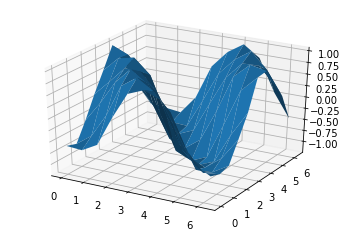

In [31]:
# Fourier transform
input_ft = fft2(input_sig)
# PSD
input_psd = (abs(input_ft))**2
# Simulating a signal
# turning noise into random signs
signs = np.sign(np.random.normal(0,1,[N, N]))
# coefficients
coefs = np.sqrt(input_psd) / N**2 * signs
# simulating
output_sig = sim2(coefs)
fig = plt.figure()
axis = fig.add_subplot(111, projection='3d')
axis.plot_surface(x, y, output_sig)
# Checking accuracy - comparing input and output PSD
output_ft2 = fft2(output_sig)
output_psd = (abs(output_ft2))**2
print("max error: ", np.max(abs(output_psd - input_psd)))
print("mean error: ", np.mean(abs(output_psd - input_psd)))